<!--NOTEBOOK_HEADER-->
*This notebook contains material from [cbe67701-uncertainty-quantification](https://ndcbe.github.io/cbe67701-uncertainty-quantification);
content is available [on Github](https://github.com/ndcbe/cbe67701-uncertainty-quantification.git).*

<!--NAVIGATION-->
< [10.1 Using GPflow package for Gaussian Process Regression](https://ndcbe.github.io/cbe67701-uncertainty-quantification/10.01-Contributed-Example.html) | [Contents](toc.html) | [11.0 Predictive Models Informed by Simulation, Measurement, and Surrogates](https://ndcbe.github.io/cbe67701-uncertainty-quantification/11.00-Predictive-Models-Informed-by-Simulation-Measurement-and-Surrogates.html)<p><a href="https://colab.research.google.com/github/ndcbe/cbe67701-uncertainty-quantification/blob/master/docs/10.02-Bayesian-quadrature.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://ndcbe.github.io/cbe67701-uncertainty-quantification/10.02-Bayesian-quadrature.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# 10.2 A simple example of Bayesian quadrature

Created by Zhuogang Peng (zpeng5@nd.edu)

These examples and codes were adapted from:

O’Hagan (1991) Bayes-Hermite Quadrature, Journal of Statistical Planning and Inference 29, pp. 245–260.

Diaconis, P. (1988). “Bayesian numerical analysis”. In:Statistical Decision Theory and Related Topics IV1,pp. 163–175.

The Emukit authors (2018), Emukit: Emulation and Uncertainty Quantification for Decision Making, https://github.com/amzn/emukit

McClarren, Ryan G (2018). Uncertainty Quantification and Predictive Computational Science: A Foundation for Physical Scientists and Engineers, Chapter 10 : Gaussian Process Emulators and Surrogate Models, Springer, https://link.springer.com/chapter/10.1007%2F978-3-319-99525-0_7


### 10.2.1 Bayesian quadrature uses Gaussian process regression as the approximation to the integrand

* We want to calculate the integral
$$
F = \int_{\mathbb{D}}f(x)\mathrm{d}x.
$$
 

* Suppose we do not know the exact expression of $f$, but we do have some observations.

* The conventional method (like trapezoid rule) cannot give the accuracy of the integration. 

* But the Bayesian method estimates the uncertainty, along with the result. It can even tell us how to select the observations.

### 10.2.2 The procedures of Bayesian Quadrature

* Using the Gaussian process as a prior distribution of $f$.

* Observe $f$ at $[x_1, x_2, ..., x_n]$ on the computational domain $\mathbb{D}$.

* Calculate the posterior distribution of $f$ with Gaussian process regression.

* The posterior $F$ is a linear functional of $f$.

* The posterior variance of $F$ does not depend on the observation $f$. This allows us to choose the quadrature points offline. 


### 10.2.3 Implementation

In [123]:
## import all needed Python libraries here
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import math
from scipy.stats import norm
from scipy.integrate import quad

# import sys
# !{sys.executable} -m pip install --user emukit
# !{sys.executable} -m pip install --user pyDOE

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C


# Figure config
LEGEND_SIZE = 16
FIGURE_SIZE = (10, 8)

For example, we are interested in 
the integral of 
$$
f(x) = x^2 e^{-x^2-2 cos^2(x)}.
$$
over $[-3, 3]$.


In [124]:
def f(x):
    return x**2*np.exp(-x**2 - 2*(np.cos(x))**2)

In [125]:
lb = -3 # lower bound
ub = 3 # upper bound

benchmark_solution = quad(f, lb, ub)
print(benchmark_solution)

(0.5369627263101916, 2.1141020263709753e-11)


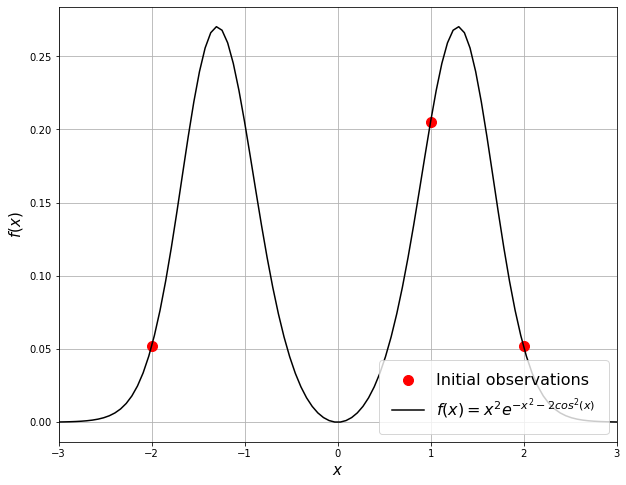

In [126]:
x_plot = np.linspace(lb, ub, 100)[:, None]

y_plot = f(x_plot)

X_init = np.array([-2,1,2])

Y_init = f(X_init)

plt.figure(figsize=FIGURE_SIZE)
plt.plot(X_init, Y_init, "ro", markersize=10, label="Initial observations")
plt.plot(x_plot, y_plot, "k", label="$f(x) =  x^2 e^{-x^2-2 cos^2(x)}$")
plt.legend(loc='lower right', prop={'size': LEGEND_SIZE}, borderpad=0.8)
plt.xlabel(r"$x$", fontsize=15)
plt.ylabel(r"$f(x)$", fontsize=15)
plt.grid(True)
plt.xlim(lb, ub)
plt.show()


#### 10.2.3.1 Take the GPR model as the surrogate

In [127]:
import GPy
X_init = X_init.reshape(-1,1)
Y_init = f(X_init)
## the squared-exponential kernel
gpy_model = GPy.models.GPRegression(X=X_init, Y=f(X_init), kernel=GPy.kern.RBF(
                        input_dim=X_init.shape[1], lengthscale=0.5, variance=1.0))

from emukit.model_wrappers.gpy_quadrature_wrappers import BaseGaussianProcessGPy, RBFGPy
from emukit.quadrature.kernels import QuadratureRBFLebesgueMeasure

emukit_rbf = RBFGPy(gpy_model.kern)
emukit_qrbf = QuadratureRBFLebesgueMeasure(emukit_rbf, integral_bounds=[[lb, ub]])
emukit_model = BaseGaussianProcessGPy(kern=emukit_qrbf, gpy_model=gpy_model)

### 10.2.4 Result

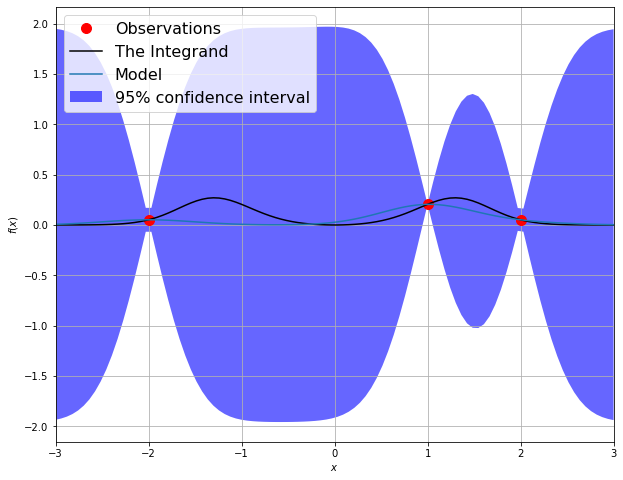

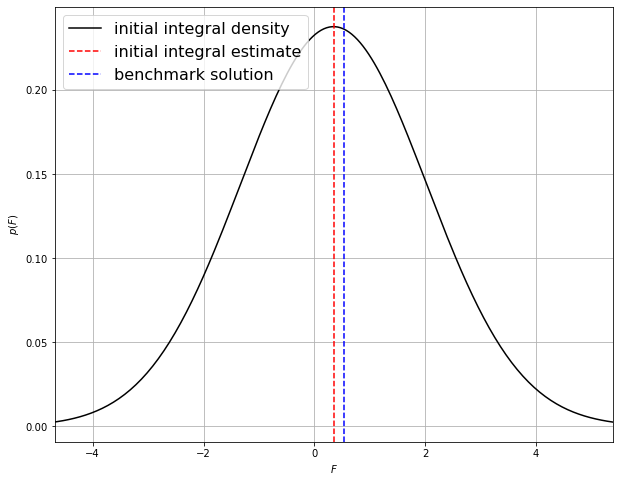

The initial estimated integral is:  0.35
with a confidence interval:  3.36 .
The ground truth rounded to 2 digits for comparison is:  0.54 .


In [128]:
from emukit.quadrature.methods import VanillaBayesianQuadrature

emukit_method = VanillaBayesianQuadrature(base_gp=emukit_model, X=X_init, Y=Y_init)

mu_plot, var_plot = emukit_method.predict(x_plot)

plt.figure(figsize=FIGURE_SIZE)
plt.plot(X_init, Y_init, "ro", markersize=10, label="Observations")
plt.plot(x_plot, y_plot, "k", label="The Integrand")
plt.plot(x_plot, mu_plot, "C0", label="Model")
plt.fill(np.concatenate([x_plot, x_plot[::-1]]),
         np.concatenate([mu_plot[:, 0] - 1.9600 * np.sqrt(var_plot)[:, 0],
                        (mu_plot[:, 0] + 1.9600 * np.sqrt(var_plot)[:, 0])[::-1]]),
         alpha=.6, fc='b', ec='None', label='95% confidence interval')
plt.legend(loc=2, prop={'size': LEGEND_SIZE})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(True)
plt.xlim(lb, ub)
plt.show()

initial_integral_mean, initial_integral_variance = emukit_method.integrate()

x_plot_integral = np.linspace(initial_integral_mean-3*np.sqrt(initial_integral_variance), 
                              initial_integral_mean+3*np.sqrt(initial_integral_variance), 200)
y_plot_integral_initial = 1/np.sqrt(initial_integral_variance * 2 * np.pi) * \
np.exp( - (x_plot_integral - initial_integral_mean)**2 / (2 * initial_integral_variance) )
plt.figure(figsize=FIGURE_SIZE)
plt.plot(x_plot_integral, y_plot_integral_initial, "k", label="initial integral density")
plt.axvline(initial_integral_mean, color="red", label="initial integral estimate", \
            linestyle="--")
plt.axvline(benchmark_solution[0], color="blue", label="benchmark solution", linestyle="--")
plt.legend(loc=2, prop={'size': LEGEND_SIZE})
plt.xlabel(r"$F$")
plt.ylabel(r"$p(F)$")
plt.grid(True)
plt.xlim(np.min(x_plot_integral), np.max(x_plot_integral))
plt.show()

print('The initial estimated integral is: ', round(initial_integral_mean, 2))
print('with a confidence interval: ', round(2*np.sqrt(initial_integral_variance), 2), '.')
print('The ground truth rounded to 2 digits for comparison is: ', round(benchmark_solution[0], 2), '.')

#### 10.2.4.1 Find the next quadrature point by minimizing the posterior variance 
* The variance $v$ of the posterior $F$ is indenpent of the function value $f(x_n)$. 

* The goal of the next step is to find $x_{n+1}$ which minimizes ${v}_n - v[\{x_i\}_{i=1}^n\cup x]$.






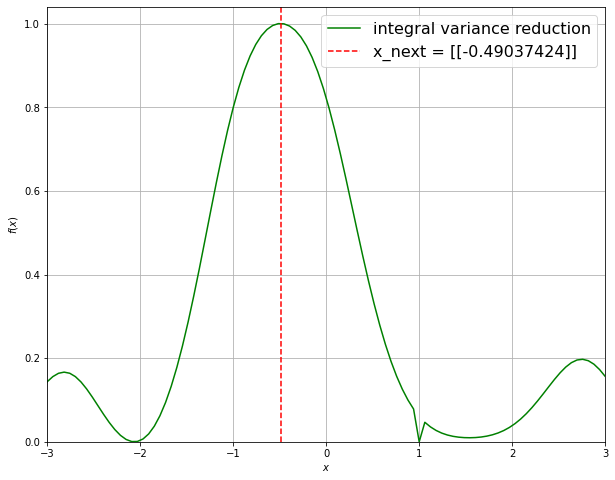

In [136]:
from emukit.quadrature.acquisitions import IntegralVarianceReduction

ivr_acquisition = IntegralVarianceReduction(emukit_method)

ivr_plot = ivr_acquisition.evaluate(x_plot)

from emukit.core.optimization import GradientAcquisitionOptimizer
from emukit.core.parameter_space import ParameterSpace

space = ParameterSpace(emukit_method.reasonable_box_bounds.convert_to_list_of_continuous_parameters())
optimizer = GradientAcquisitionOptimizer(space)
x_new,_ = optimizer.optimize(ivr_acquisition)

plt.figure(figsize=FIGURE_SIZE)
plt.plot(x_plot, (ivr_plot - np.min(ivr_plot)) / (np.max(ivr_plot) - np.min(ivr_plot)), 
         "green", label="integral variance reduction")
plt.axvline(x_new, color="red", label="x_next = {}".format(x_new), linestyle="--")
plt.legend(loc=0, prop={'size': LEGEND_SIZE})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(True)
plt.xlim(lb, ub)
plt.ylim(0, 1.04)
plt.show()


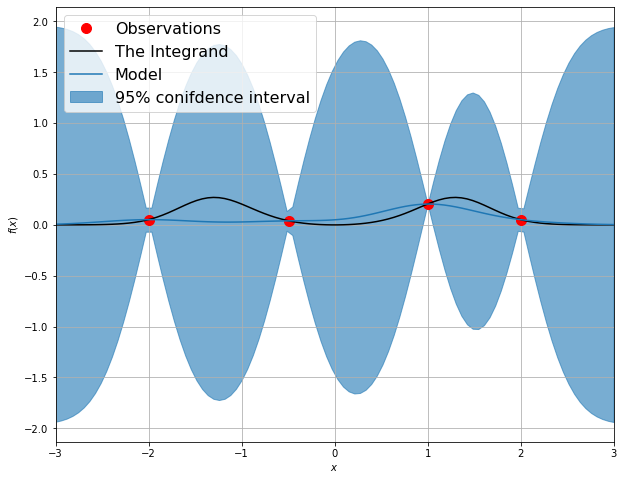

In [141]:
y_new = f(x_new)
X = np.append(X_init, x_new, axis=0)
Y = np.append(Y_init, y_new, axis=0)

emukit_method.set_data(X, Y)

mu_plot, var_plot = emukit_model.predict(x_plot)

plt.figure(figsize=FIGURE_SIZE)
plt.plot(emukit_model.X, emukit_model.Y, "ro", markersize=10, label="Observations")
plt.plot(x_plot, y_plot, "k", label="The Integrand")
plt.plot(x_plot, mu_plot, "C0", label="Model")
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 1.96*np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 1.96*np.sqrt(var_plot)[:, 0], color="C0", alpha=0.6, label = '95% conifdence interval')
plt.legend(loc=2, prop={'size': LEGEND_SIZE})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(True)
plt.xlim(lb, ub)
plt.show()

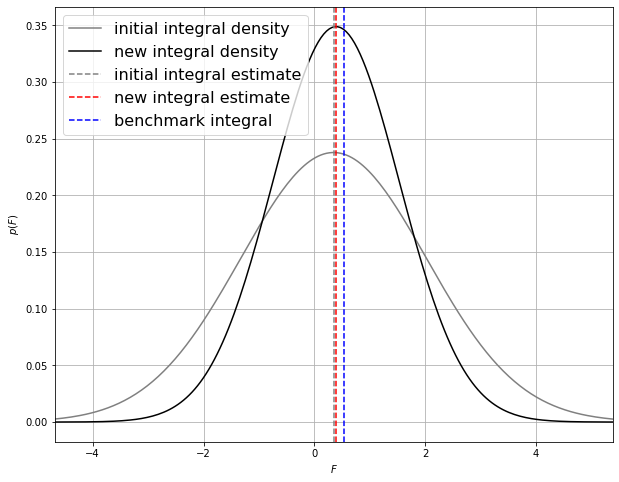

The initial estimated integral is:  0.35
with a confidence interval:  3.36 .
The second estimated integral is:  0.39
with a confidence interval:  2.29 .
The benchmark solution rounded with 2 digits is:  0.54 .


In [143]:
integral_mean, integral_variance = emukit_method.integrate()
y_plot_integral = 1/np.sqrt(integral_variance * 2 * np.pi) * \
np.exp( - (x_plot_integral - integral_mean)**2 / (2 * integral_variance) )
plt.figure(figsize=FIGURE_SIZE)
plt.plot(x_plot_integral, y_plot_integral_initial, "gray", label="initial integral density")
plt.plot(x_plot_integral, y_plot_integral, "k", label="new integral density")
plt.axvline(initial_integral_mean, color="gray", label="initial integral estimate", linestyle="--")
plt.axvline(integral_mean, color="red", label="new integral estimate", linestyle="--")
plt.axvline(benchmark_solution[0], color="blue", label="benchmark integral", \
            linestyle="--")
plt.legend(loc=2, prop={'size': LEGEND_SIZE})
plt.xlabel(r"$F$")
plt.ylabel(r"$p(F)$")
plt.grid(True)
plt.xlim(np.min(x_plot_integral), np.max(x_plot_integral))
plt.show()
print('The initial estimated integral is: ', round(initial_integral_mean, 2))
print('with a confidence interval: ', round(2*np.sqrt(initial_integral_variance), 2),'.')
print('The second estimated integral is: ', round(integral_mean, 2))
print('with a confidence interval: ', round(2*np.sqrt(integral_variance), 2),'.')
print('The benchmark solution rounded with 2 digits is: ', round(benchmark_solution[0], 2),'.')

<!--NAVIGATION-->
< [10.1 Using GPflow package for Gaussian Process Regression](https://ndcbe.github.io/cbe67701-uncertainty-quantification/10.01-Contributed-Example.html) | [Contents](toc.html) | [11.0 Predictive Models Informed by Simulation, Measurement, and Surrogates](https://ndcbe.github.io/cbe67701-uncertainty-quantification/11.00-Predictive-Models-Informed-by-Simulation-Measurement-and-Surrogates.html)<p><a href="https://colab.research.google.com/github/ndcbe/cbe67701-uncertainty-quantification/blob/master/docs/10.02-Bayesian-quadrature.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://ndcbe.github.io/cbe67701-uncertainty-quantification/10.02-Bayesian-quadrature.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>